In [ ]:
import math
import pandas_datareader as web 
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM 
import matplotlib.pyplot as plt
import yfinance as yf

: 

In [ ]:
# Scarica i dati di una azione specifica da Yahoo Finance all'interno del periodo specificato
ticker = "AAPL"
start_date = "2011-01-01"
end_date = "2020-01-01"
percDataTraning = 0.9   #percentuale dei dati dedicati al traning
df = yf.download(ticker, start=start_date, end=end_date)

#stampa grafico dello storico considerando solo la colonna close
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18) 
plt.show()

: 

Elaborazione dati

In [ ]:
#Crea un nuovo dataframe con solo la colonna "Close"
data = df.filter (['Close'])
#Converti il dataframe in numpy array
dataset = data.values
#Prendi il numero di righe da usare per il traning
training_data_len = math.ceil(len(dataset) * percDataTraning )
training_data_len

#Scala (normalizza) i dati    ->    converte i valori da 0 a 1 e si salva il massimo e il minimo all'interno dello scaler
scaler = MinMaxScaler(feature_range= (0,1))
scaled_data = scaler.fit_transform(dataset)

#Crea il dataset per il training prendendo i dati scalati dal indice 0 a training_data_len
train_data = scaled_data[0:training_data_len, :]
#x_train contiene le sequenze temporali (60 giorni) e y_train i risultato della relativa sequenza
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0]) 
  y_train.append(train_data[i, 0]) 
  #debug
  if i <= 60:
    print(x_train)
    print(y_train)
    print()

x_train, y_train = np.array(x_train), np.array(y_train) #converte in array

#modifica la "forma" del array 2D (numSeqTemporali x lenSeqtemporali) in 3D (numSeqTemporali x lenSeqtemporali x numCaratteristiche)
#in parole povere aggiunge una dimensione dedicata alle caratteristiche, che nel nosto caso sara 1 perche consideriamo solo il close
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
x_train.shape #debug (stampa dimensione della matrice)

[array([0.00818857, 0.00917695, 0.0107342 , 0.01057907, 0.01195244,
       0.01558989, 0.01512445, 0.01672191, 0.01744596, 0.01905494,
       0.01455554, 0.01351546, 0.00997569, 0.00655085, 0.01271672,
       0.01498652, 0.01639438, 0.01602661, 0.01194093, 0.01379127,
       0.01707246, 0.01666446, 0.01615877, 0.01791717, 0.02100872,
       0.0229165 , 0.02461743, 0.02253725, 0.02386466, 0.02520356,
       0.02561729, 0.02747339, 0.02469788, 0.0202502 , 0.01338328,
       0.01568759, 0.01583698, 0.01887107, 0.02177298, 0.0195319 ,
       0.02114662, 0.02542193, 0.02567477, 0.02300846, 0.0232383 ,
       0.02134774, 0.01801485, 0.02107191, 0.0219741 , 0.01730232,
       0.0084414 , 0.01110199, 0.00882067, 0.01377978, 0.01487159,
       0.01371658, 0.01703798, 0.02081334, 0.02018123, 0.02048005])]
[0.019141134004356603]



(1978, 60, 1)

Creazione e addestramemnto modello

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(100, return_sequences=False)) 
model.add(Dense(50)) 
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')  #mean_squared_error è come viene valutata la bonta del valore predetto
#addestra il modello facendo 5 cicli (epoche)
model.fit(x_train, y_train, batch_size=1, epochs=5)
#Salva il modello su disco
model.save("aapl_model.h5")

In [ ]:
#Carica il modello da disco
model = load_model("aapl_modeltipo2.h5")

Creazione e elaborazione dati di test

In [ ]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)) :
  x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

Predizione e analisi dati di test

8/8 [==============================] - 1s 16ms/step
0.2432282878234323


/var/folders/2d/pr766pxd7zd224klgmt0_5w00000gn/T/ipykernel_97623/926656392.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


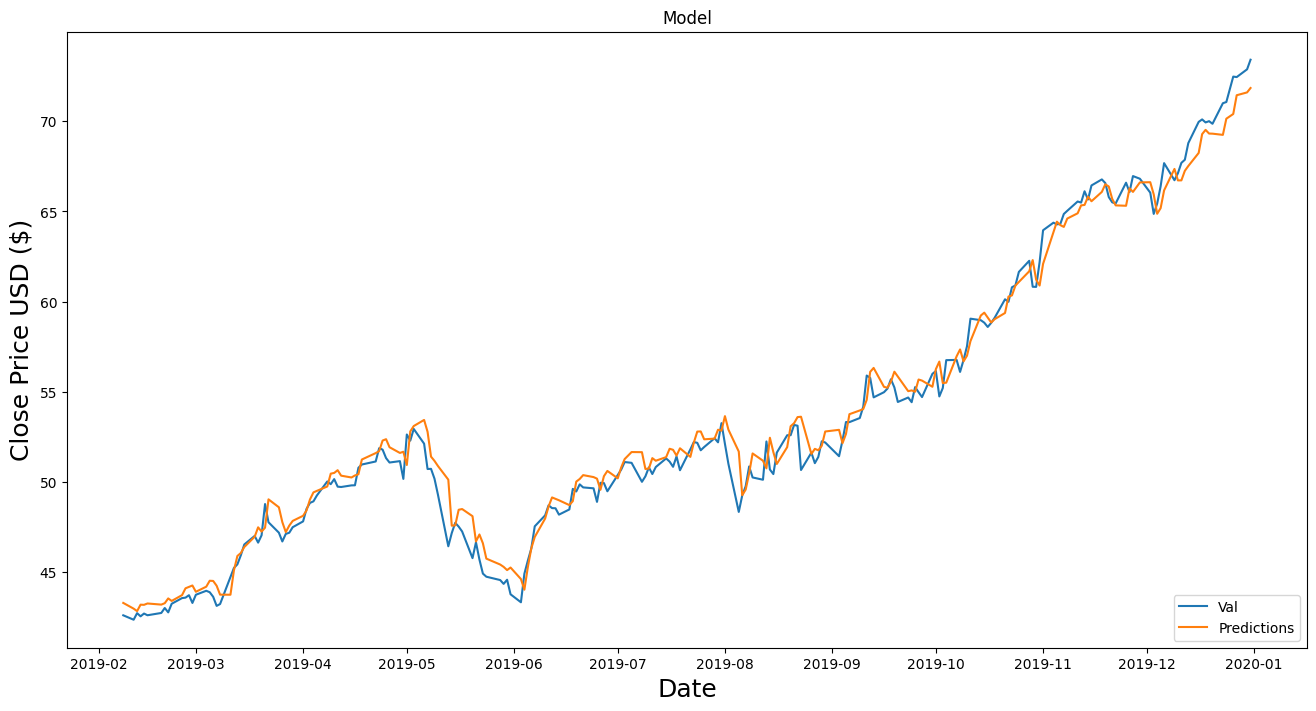

In [ ]:
#calcola le predizioni
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #USARE STESSO SCALER DEL ADDESTRAMENTO

#calcolamento del root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print(rmse)

#stampa il grafico dei dati
#train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
#plt.plot(train['Close'])
plt.plot (valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

Predizione puntuale di un solo dato

In [ ]:
#spesso la predizione di altre azioni o di periodi temporali dopo il 2020 (per colpa della pandemia) sono sballate di alcuni giorni, sarebbe consigliata una analisi grafica per comprendere meglio l'andamento del modello

quote =  yf.download(ticker, start="2012-01-01", end="2021-1-31")
new_df = quote.filter(['Close'])
last_60_days = new_df[-60:].values  #prendi solo i dati dei precedenti 60 giorni per creare la sequenza temporale
last_60_days_scaled = scaler.transform(last_60_days) #USARE STESSO SCALER DEL ADDESTRAMENTO
x_test = []
x_test.append(last_60_days_scaled)
x_test = np.array (x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = model.predict(x_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

#scarica e stampa la quota puntuale del giorno dopo per confronto
apple_quote2 = yf.download(ticker, start="2021-1-29", end="2021-2-1")
print(apple_quote2['Close'])

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 12ms/step
[[113.22058]]
[*********************100%***********************]  1 of 1 completed
Date
2021-01-29    131.960007
Name: Close, dtype: float64
